# For the brownian particle from the [Nature paper](https://www.nature.com/articles/s41567-020-1018-2), does time asymetry with the distance between work distributions?  

## To answer that, let's first parametrize brownian particle in such a way that allows us to control the distance between forward and backward work distributions directly

In [1]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from brownian_datagen import BrownianDatagen

In [3]:
def work_distribution_distance(b: BrownianDatagen) -> float:
    _, work_f = b.generate(numParticles=10000)
    _, work_b = b.generate(numParticles=10000, backward=True)
    return wasserstein_distance(work_f, work_b)

def work_distribution_meandiff(b: BrownianDatagen) -> float:
    _, work_f = b.generate(numParticles=10000)
    _, work_b = b.generate(numParticles=10000, backward=True)
    return work_f.mean() - work_b.mean()

def plot_work_distribution_histograms(b: BrownianDatagen, bins: int = 30) -> None:
    _, work_f = b.generate(numParticles=10000)
    _, work_b = b.generate(numParticles=10000, backward=True)

    fig, ax = plt.subplots()
    
    ax.set_title("Work distributions")
    ax.hist(work_f, bins=bins, color="red", label="forward", alpha=0.5)
    ax.hist(work_b, bins=bins, color="blue", label="backward", alpha=0.5)
    ax.grid()
    ax.legend()

    return fig, ax

gamma=1, work distribution distance: 4.342049380366323
gamma=2, work distribution distance: 8.676385837813884
gamma=5, work distribution distance: 18.73681219777195
gamma=10, work distribution distance: 28.39644627060042
gamma=20, work distribution distance: 36.83584955989618
gamma=30, work distribution distance: 40.574331041030526


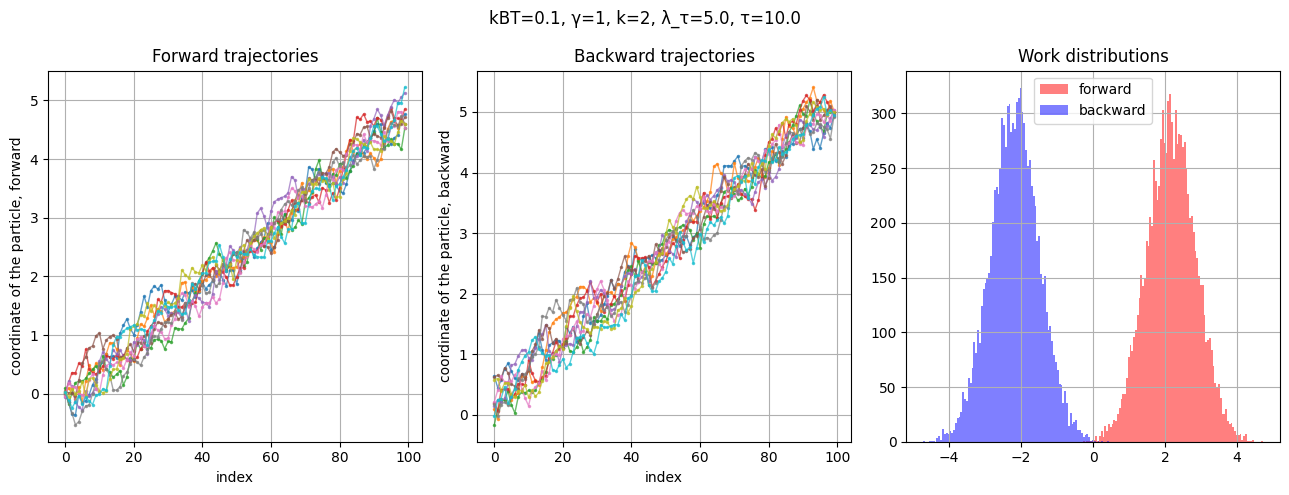

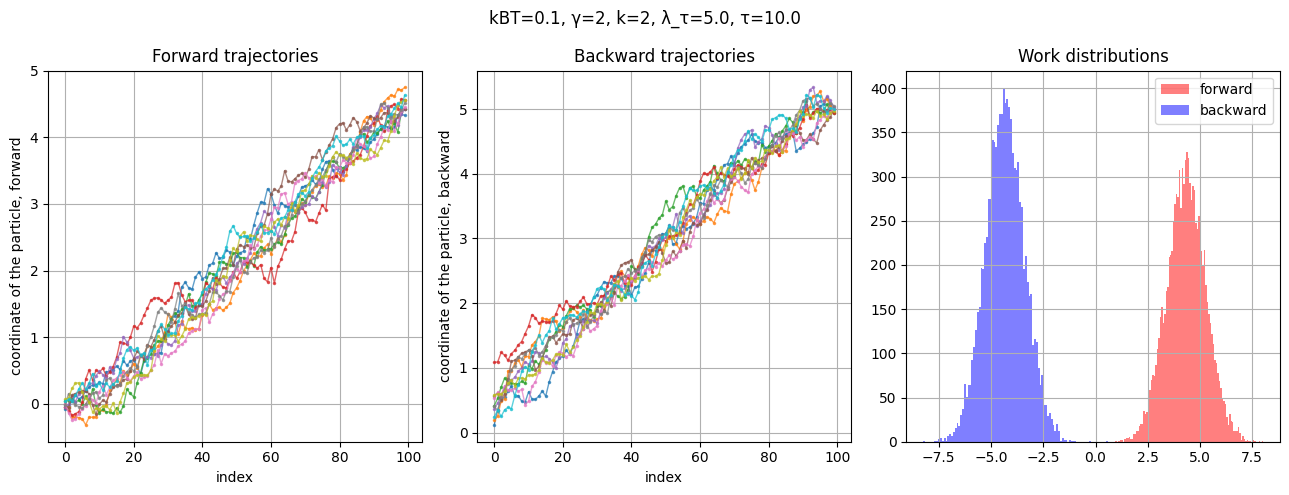

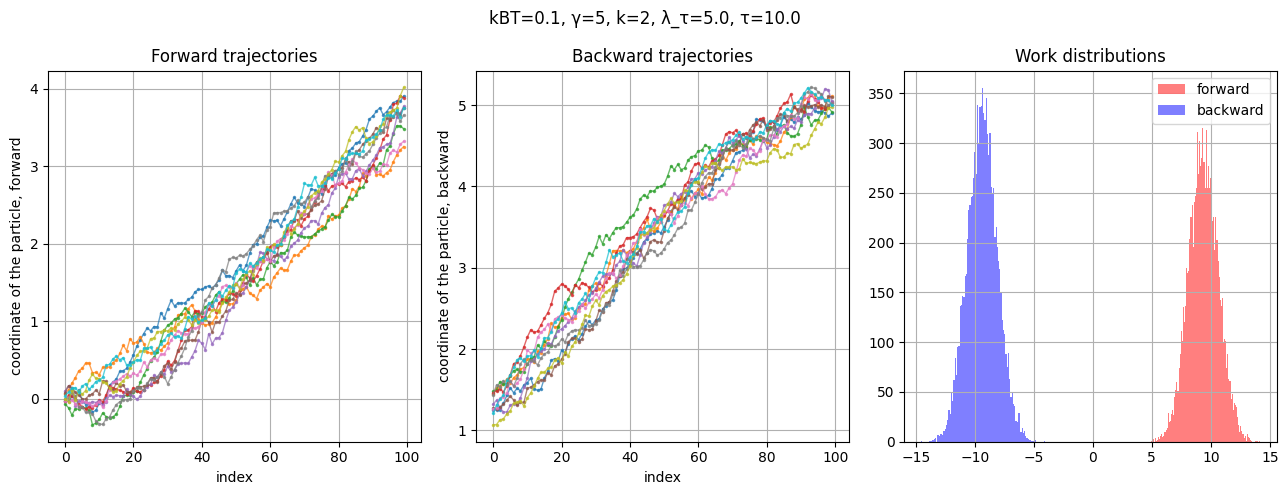

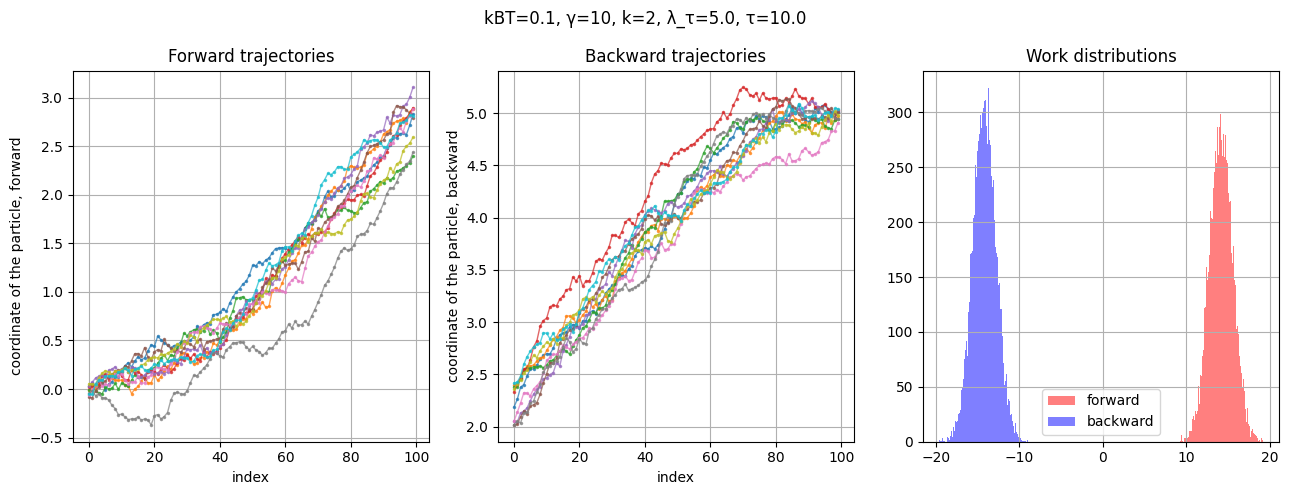

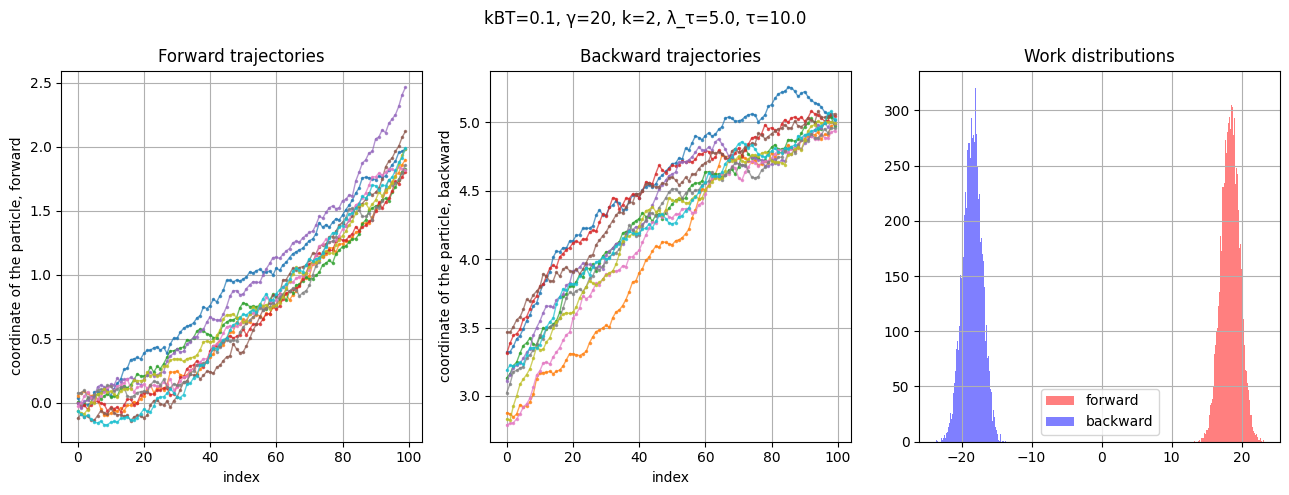

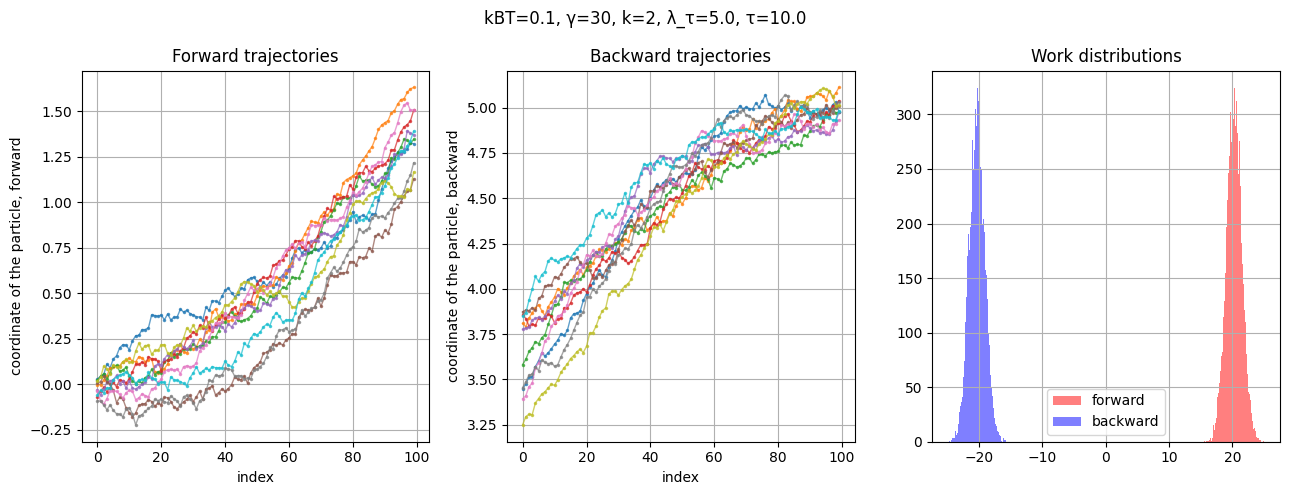

In [4]:
for gamma in [1, 2, 5, 10, 20, 30]:
    b = BrownianDatagen(kBT=0.1, γ=gamma, k=2, λ_τ=5., τ=10.)
    print(f"gamma={gamma},", "work distribution distance:", work_distribution_distance(b))
    b.visualize(landscape_layout=True)

## We see that the $\gamma$ parameter, the friction coefficient aka damping rate, is responsible for the separation between the forward and backward work distributions. The distributions move away from each other as $\gamma$ increases.
## Let's see if difference in loss forward and backward prediction (our time asymmetry metric) increases with $\gamma$ 

In [5]:
import os
import torch
from typing import List

In [6]:
from brownian_datagen import create_dataholder_for_windows_and_targets
from bayesian_varinf import train_fb_n_times, load_learning_curves

In [7]:
def get_save_dir_prefix(gamma: float) -> str:
    save_dir_prefix = "20230724_preds/brownian_varinf_vary_gamma/"
    return os.path.join(save_dir_prefix, f"gamma={gamma:.03f}/")

gamma_grid = (1., 2., 5., 10., 20., 30.)

In [8]:
print("values for gamma:", gamma_grid)
for gamma in gamma_grid:
    print(f"gamma={gamma}/")
    brownian = BrownianDatagen(kBT=0.1, γ=gamma, k=2., λ_τ=5., τ=10.)
    dt = create_dataholder_for_windows_and_targets(brownian, numParticles=30,
                                                   window_len=6, # NEW WINDOW_LEN!
                                                   rng_seed=42)

    save_dir_prefix = get_save_dir_prefix(gamma)
    train_fb_n_times(dt, num_runs=30,
                 num_epochs=4000, save_metrics_every_n_epochs=100,
                 hidden_size=10, train_test_split_ratio=0.5,
                 save_dir_prefix=save_dir_prefix)

values for gamma: (1.0, 2.0, 5.0, 10.0, 20.0, 30.0)
gamma=1.0/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100422.28it/s]


gamma=2.0/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86838.59it/s]


gamma=5.0/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86302.55it/s]


gamma=10.0/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71210.59it/s]


gamma=20.0/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82619.25it/s]


gamma=30.0/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101721.20it/s]


## Models trained, now explore the results (learning curves)

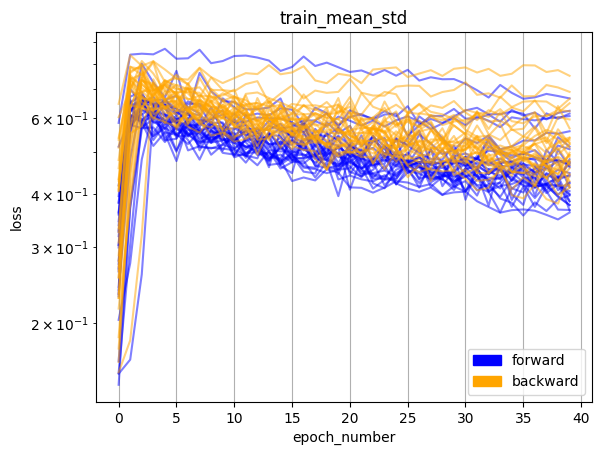

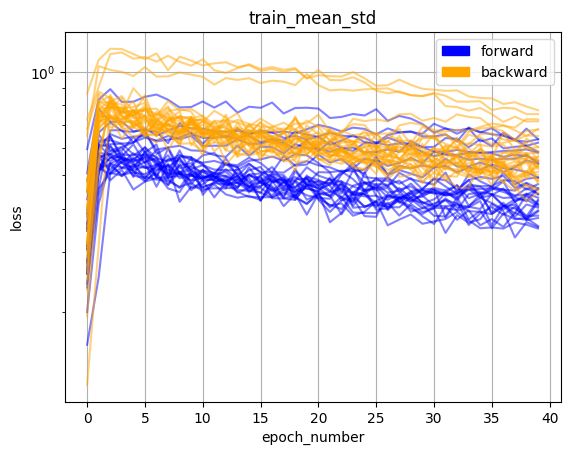

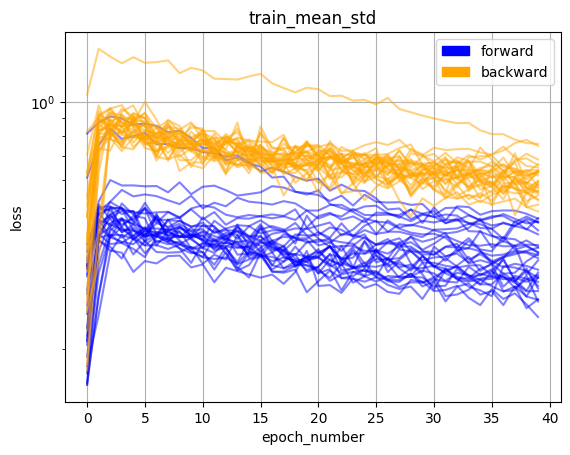

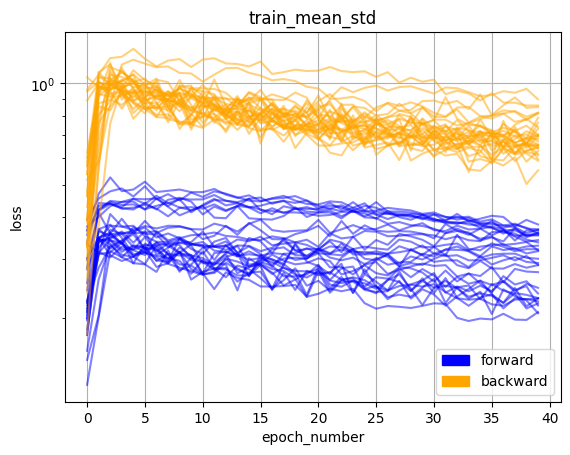

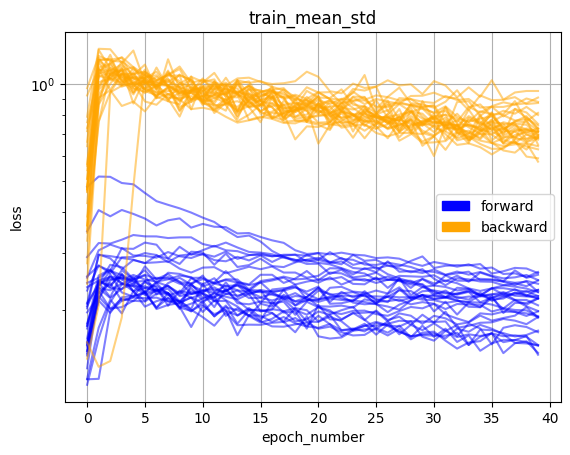

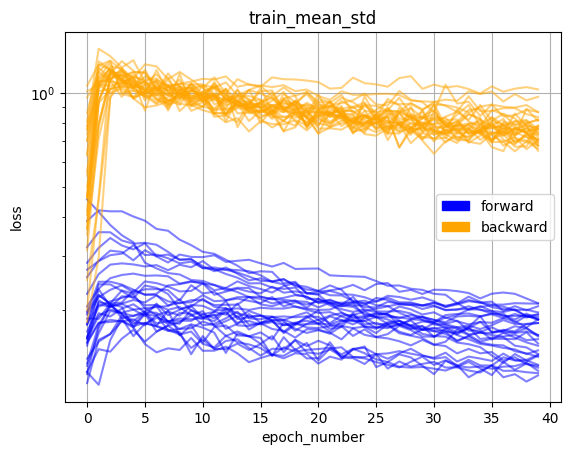

In [9]:
for gamma in gamma_grid:
    save_dir_prefix = get_save_dir_prefix(gamma)
    l = load_learning_curves(save_dir_prefix, num_runs=30, alt_metric="train_mean_std")
    l.plot_learning_curves()

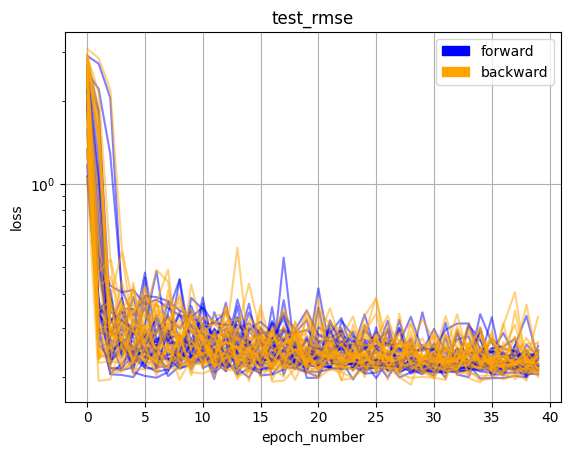

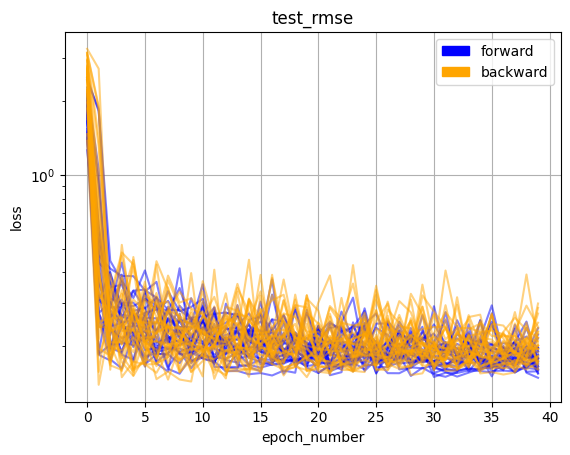

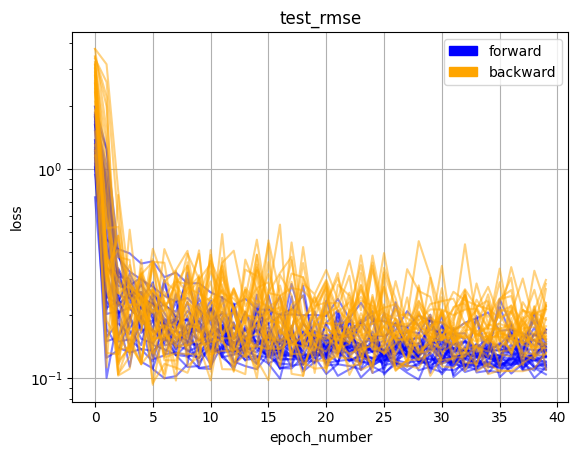

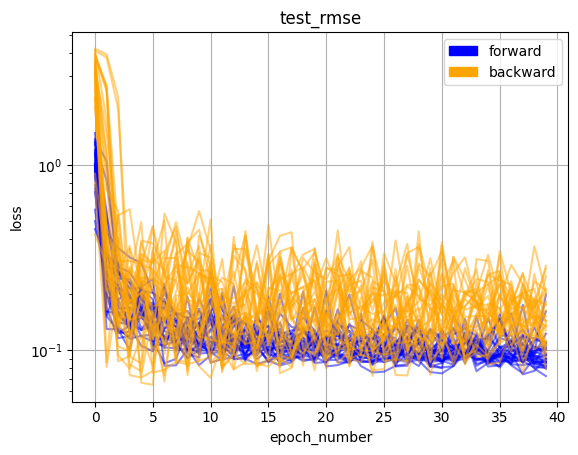

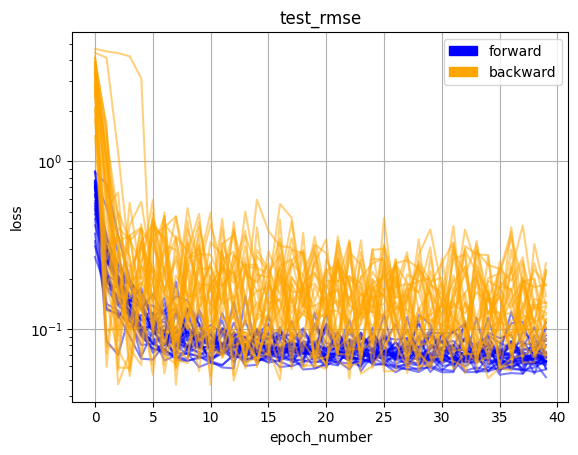

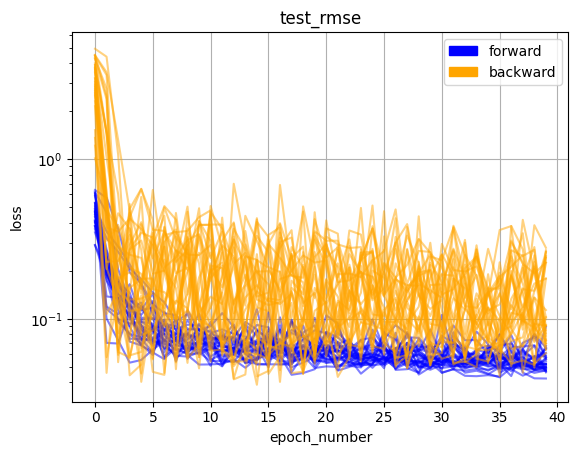

In [10]:
for gamma in gamma_grid:
    save_dir_prefix = get_save_dir_prefix(gamma)
    l = load_learning_curves(save_dir_prefix, num_runs=30, alt_metric="test_rmse")
    l.plot_learning_curves()

Text(0.5, 1.0, 'Our asymmetry metric increases with gamma')

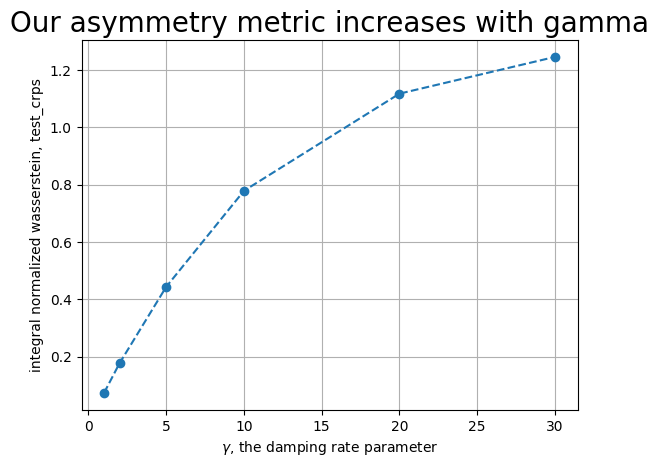

In [11]:
metric: str = "test_crps" # "train_rmse"
asymmetry = []
for gamma in gamma_grid:
    save_dir_prefix = get_save_dir_prefix(gamma)
    l = load_learning_curves(save_dir_prefix, num_runs=30, alt_metric=metric)
    m = l.integral_normalized_wasserstein()
    asymmetry.append(m)

plt.plot(gamma_grid, asymmetry, "o--")
plt.grid()
plt.xlabel("$\gamma$, the damping rate parameter")
plt.ylabel("integral normalized wasserstein, " + metric)
plt.title("Our asymmetry metric increases with gamma", size=20)